In [3]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

this dataset is obtained from Kaggle [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

This dataset contains 11 features that can be used to predict possible heart disease.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

the variables:

- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

Are *categorical*, so we must one-hot encode them. 

In [4]:
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
# let's one hot encode these 5 categorical features

# we will remove the binary variables, because one-hot encoding wouldn't do anything to them
cat_variables = ['Sex',
                 'ChestPainType',
                 'RestingECG',
                 'ExerciseAngina',
                 'ST_Slope'
            ]

Pandas has a built-in method to one-hot encode variables, it is the function `pd.get_dummies`. There are several arguments to this function, but here we will use only a few. They are:

 - data: DataFrame to be used
 - prefix: A list with prefixes, so we know which value we are dealing with
 - columns: the list of columns that will be one-hot encoded. 'prefix' and 'columns' must have the same length.

In [6]:
# this will replace the columns with the one-hot encoded ones
df = pd.get_dummies(data = df, prefix=cat_variables, columns=cat_variables)
# 'prefix' adds a prefix to the new one-hot encoded columns names

df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True


variables that will be the input features of the model.
- The target is `HeartDisease`.
- All other variables are features that can potentially be used to predict the target, `HeartDisease`.

In [7]:
features = [x for x in df.columns if x not in 'HeartDisease']  # all columns except target

In [9]:
print(len(features))  # total number of features after one-hot encoding. we started with 11 for ref

20


In [10]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size=0.8, random_state=42)

print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 734
validation samples: 184
target proportion: 0.5463


hyperparameters we will use and investigate here are:

 - min_samples_split: The minimum number of samples required to split an internal node. 
   - Choosing a higher min_samples_split can reduce the number of splits and may help to reduce overfitting.
 - max_depth: The maximum depth of the tree. 
   - Choosing a lower max_depth can reduce the number of splits and may help to reduce overfitting.

In [11]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]
max_depth_list = [1, 2, 3, 4, 8, 16, 32, 64, None]  # None means no depth limit

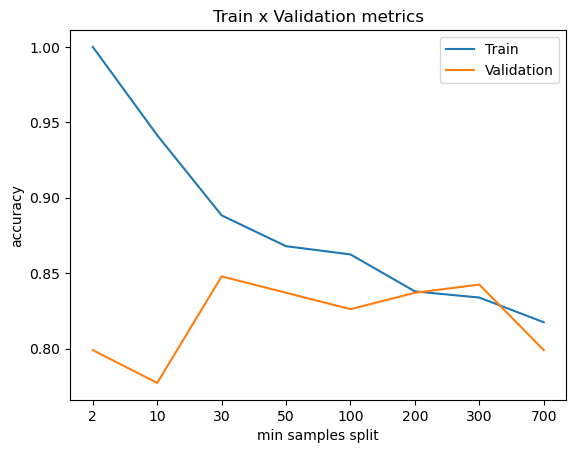

In [12]:
# experimenting with min_samples_split
accuracy_list_train = []
accuracy_list_val = []

for min_samples_split in min_samples_split_list:
    # defining and fitting the model
    model = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=42).fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min samples split')
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)  # used to set custom x-axis tick marks and labels
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

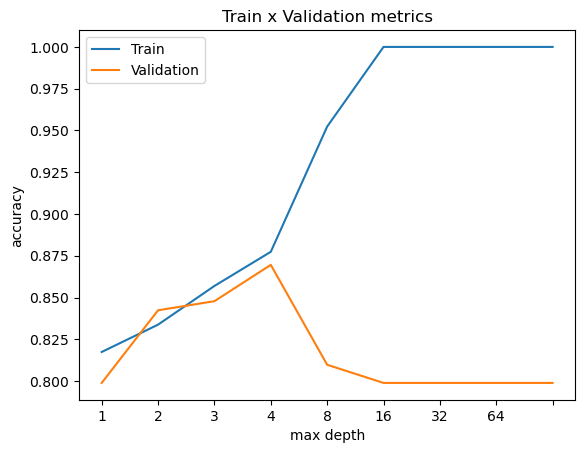

In [13]:
# experimenting with max_depth
accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list:
    # defining and fitting the model
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42).fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)  # used to set custom x-axis tick marks and labels
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

So we can choose the hyperparameters:
- max_depth = 4
- min_samples_split = 50

In [14]:
decision_tree_model = DecisionTreeClassifier(min_samples_split=50, max_depth=4, random_state=42).fit(X_train, y_train)

In [15]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8583
Metrics validation:
	Accuracy score: 0.8370


### Random Forests

In [17]:
# n_estimators which is the number of Decision Trees that make up the Random Forest
n_estimators_list = [10, 50, 100, 500]

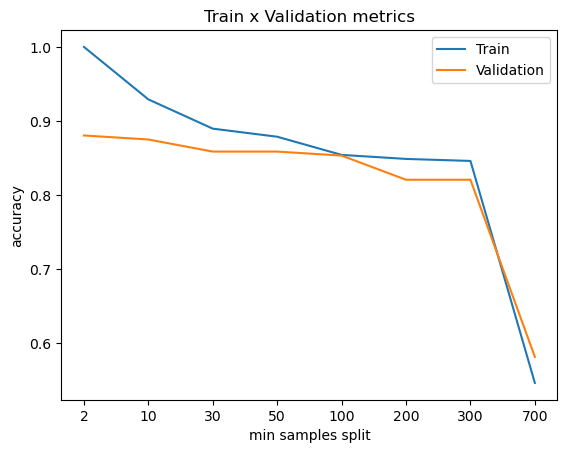

In [18]:
# experimenting with min_samples_split
accuracy_list_train = []
accuracy_list_val = []

for min_samples_split in min_samples_split_list:
    # defining and fitting the model
    model = RandomForestClassifier(min_samples_split=min_samples_split, random_state=42).fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min samples split')
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)  # used to set custom x-axis tick marks and labels
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

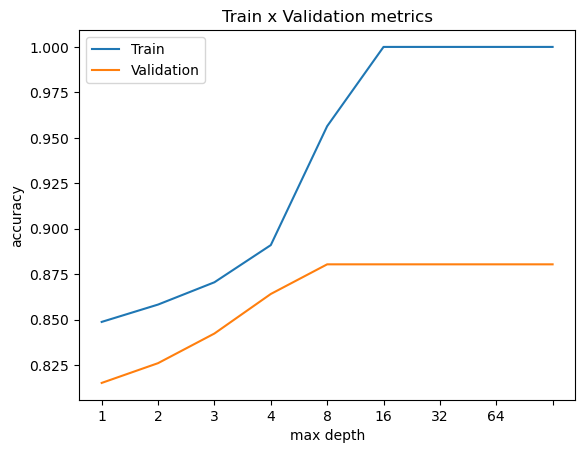

In [19]:
# experimenting with max_depth
accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list:
    # defining and fitting the model
    model = RandomForestClassifier(max_depth=max_depth, random_state=42).fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)  # used to set custom x-axis tick marks and labels
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

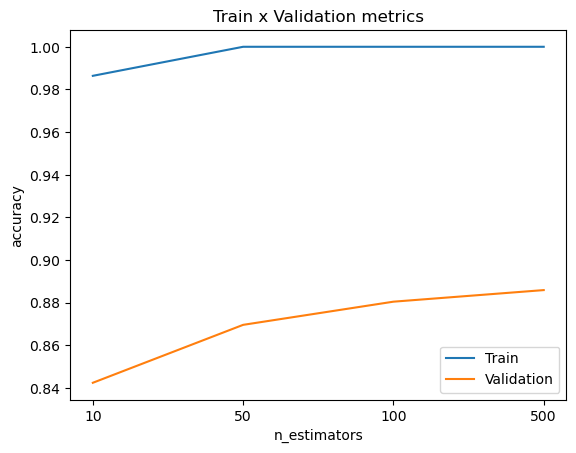

In [20]:
# experimenting with n_estimators
accuracy_list_train = []
accuracy_list_val = []

for n_estimators in n_estimators_list:
    # defining and fitting the model
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42).fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)  # used to set custom x-axis tick marks and labels
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

Let's then fit a random forest with the following parameters:

 - max_depth: 16
 - min_samples_split: 10
 - n_estimators: 100

In [21]:
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=16, min_samples_split=10).fit(X_train, y_train)

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9305
Metrics test:
	Accuracy score: 0.8804


### XGBoost

In [22]:
n = int(len(X_train) * 0.8)  # let's use 80% of train set for training, and 20% for eval

X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

- `eval_set = [(X_train_eval,y_train_eval)]`:Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. 
- `early_stopping_rounds`: This parameter helps to stop the model training if its evaluation metric is no longer improving on the validation set. It's set to 10.


In [30]:
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, verbosity=1, early_stopping_rounds = 10, random_state=42)
xgb_model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)])

[0]	validation_0-logloss:0.65141
[1]	validation_0-logloss:0.61289
[2]	validation_0-logloss:0.57971
[3]	validation_0-logloss:0.55172
[4]	validation_0-logloss:0.53175
[5]	validation_0-logloss:0.51401
[6]	validation_0-logloss:0.49884
[7]	validation_0-logloss:0.48808
[8]	validation_0-logloss:0.47906
[9]	validation_0-logloss:0.47016
[10]	validation_0-logloss:0.46099
[11]	validation_0-logloss:0.45347
[12]	validation_0-logloss:0.44867
[13]	validation_0-logloss:0.44370
[14]	validation_0-logloss:0.44137
[15]	validation_0-logloss:0.43769
[16]	validation_0-logloss:0.43645
[17]	validation_0-logloss:0.43211
[18]	validation_0-logloss:0.43149
[19]	validation_0-logloss:0.42899
[20]	validation_0-logloss:0.42878
[21]	validation_0-logloss:0.42753
[22]	validation_0-logloss:0.42596
[23]	validation_0-logloss:0.42669
[24]	validation_0-logloss:0.42381
[25]	validation_0-logloss:0.42547
[26]	validation_0-logloss:0.42418
[27]	validation_0-logloss:0.42022
[28]	validation_0-logloss:0.41854
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [32]:
xgb_model.best_iteration  # the round with the best metrics

33

In [33]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9469
Metrics test:
	Accuracy score: 0.8750
